# CP1 - (DS트랙) 이진 분류 인공신경망 프로그래밍

## 프로젝트 개요 
    - (DS 트랙) 0과 1을 분류하는 인공신경망 프로그래밍 (from Scratch)
    - 딥러닝 라이브러리(Tensorflow, Keras, PyTorch 등)을 사용하지 않고 numpy 등으로 직접 구현하는 프로젝트 
    
1. 지정 과제
    - 입력층, 출력층, 순전파까지만 구현 
    - **[실행 결과]** 과제용 지정 데이터에 적용 
2. 모델 개선 (1)단계: 역전파 추가 
    - 역전파 추가: 가중치와 편향 손실 기울기와 학습률을 활용하여 학습 수행 
    - 데이터 처리: 불균형 데이터 처리, 데이터 표준화 처리 
    - 평가 지표 추가: 정밀도, 재현율, F1 값 추가 
    - **[실행 결과]** 과제용 지정 데이터에 적용  
3. 모델 개선 (2)단계: 은닉층 추가
    - 은닉층 구조 지정 및 그에 따른 가중치 초기화, 역전파, 순전파 각각 구현 
    - **[실행 결과]** 과제용 지정 데이터에 은닉층 추가 모델(최종 모델) 적용 
    - **[실행 결과]** 새로운 데이터에 은닉층 추가 모델(최종 모델) 적용  
      - 데이터: Web page Phishing Detection Dataset (출처: 캐글)

## Part 1. 지정 과제 
- 입력층, 출력층, 순전파까지만 구현 

- 과제용 지정 데이터 다운로드 
- url: https://drive.google.com/file/d/1SCO0ZGL_EDGWc9Le0JFDw9eww86xk1xJ/view?usp=share_link

In [1]:
# 활용할 수 있는 라이브러리 (제한 조건)
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

# 랜덤 시드 고정 (동일한 결과 도출) 
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 하이퍼 파라미터 설정 
FILE_PATH = '/Users/ju/datasets/cp1/binary_dataset.csv'
TARGET = 'y'
RANDOM_MEAN = 0
RANDOM_STD = 0.0030
TRAIN_SIZE = 0.8
LEARNING_RATE = 0.001

### 과제용 지정 데이터 탐색

In [2]:
# 데이터 탐색 
df = pd.read_csv(FILE_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      20 non-null     float64
 1   x2      20 non-null     float64
 2   x3      20 non-null     float64
 3   x4      20 non-null     float64
 4   x5      20 non-null     float64
 5   x6      20 non-null     float64
 6   x7      20 non-null     float64
 7   x8      20 non-null     float64
 8   y       20 non-null     int64  
dtypes: float64(8), int64(1)
memory usage: 1.5 KB


In [3]:
# 데이터 크기 
df.shape

(20, 9)

In [4]:
# 기술 통계 값 확인 -> 상이한 분포 확인 
df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,y
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,108.519922,44.958603,0.917961,4.245494,20.604264,34.753079,6.894552,80.950846,0.300000
std,32.477254,7.694328,1.690410,11.182930,35.887920,23.593768,4.985674,96.223854,0.470162
min,23.625000,28.666042,-0.045909,-0.438858,0.781773,10.570833,-0.274902,-1.183162,0.000000
25%,100.509766,40.514392,0.122908,-0.297330,2.092809,16.495204,2.600383,5.871250,0.000000
50%,117.417969,46.090240,0.328466,0.348761,3.962375,23.107198,6.979925,52.896723,0.000000
75%,127.873047,51.304149,0.586270,1.472283,22.469482,55.009240,9.516857,96.511706,1.000000
max,141.968750,53.348784,5.770087,37.419009,146.568562,82.394624,17.118300,339.660826,1.000000


In [5]:
# 결측치 확인 -> 없음 
df.isnull().sum()

x1    0
x2    0
x3    0
x4    0
x5    0
x6    0
x7    0
x8    0
y     0
dtype: int64

In [6]:
# 중복값 확인 -> 없음 
df.duplicated().sum()

0

In [7]:
# 기준 모델 (baseline model) - 불균형 데이터 (정확도 70%) 
# 향후 불균형 데이터를 균형 데이터로 바꿔주는 작업을 수행해 결과를 비교해 볼 필요가 있음.
df[TARGET].value_counts(normalize = True)

0    0.7
1    0.3
Name: y, dtype: float64

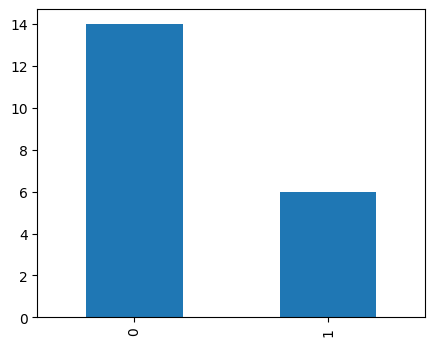

In [8]:
# 기준 모델 (baseline model) - 시각화 
plt.figure(figsize=(5, 4))
df[TARGET].value_counts().plot(kind = 'bar')
plt.savefig('target_barplot.png')

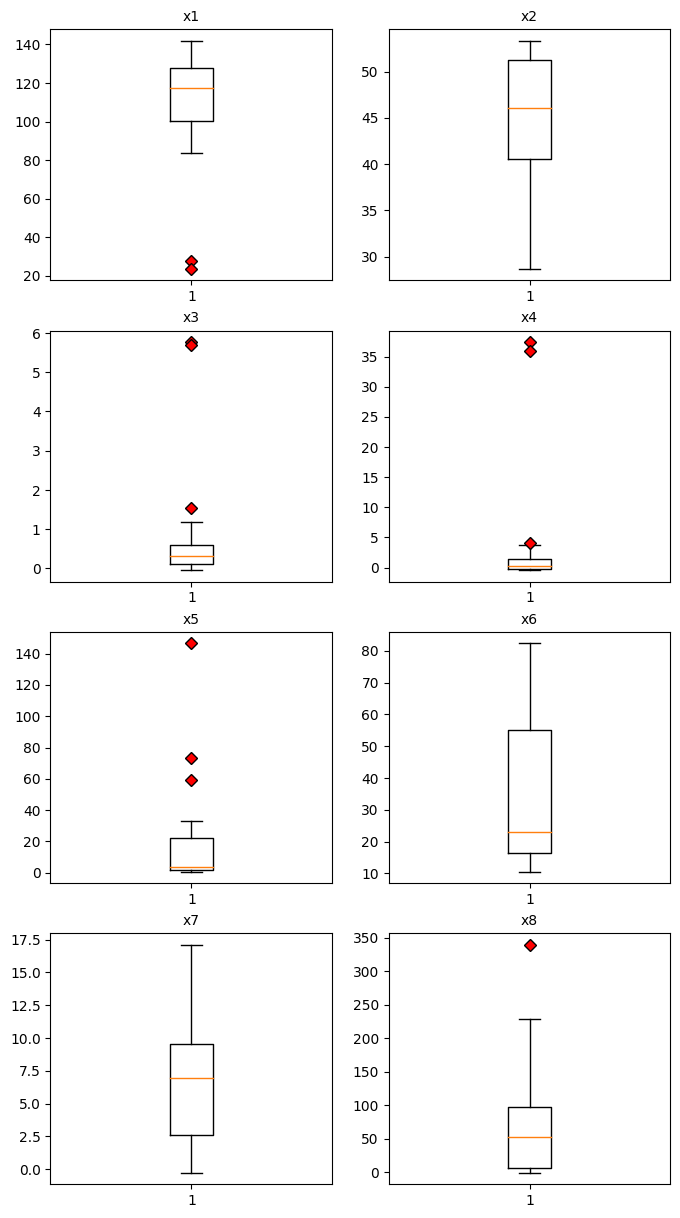

In [9]:
# features 분포 확인 -> 이상치 확인 
# 향후 제대로 된 학습을 위해서는 데이터 표준화 / 정규화 과정을 거치는 것을 고려해 볼 수 있음. 

def data_boxplot_vis(data = df.drop(columns=[TARGET])):
    """
    매개변수
        data: 피쳐만 담은 데이터 프레임
    """
    plt.figure(figsize=(8, 15))
    for col_idx in range(len(data.columns)):
        # 서브 플롯에 각 feature 박스플롯 시각화
        plt.subplot(len(data.columns) // 2, 2, col_idx+1)
        # flierprops: 빨간색 다이아몬드 모양으로 이상치 시각화
        plt.boxplot(data[data.columns[col_idx]], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
        # 그래프 저장
        plt.title(data.columns[col_idx], fontsize = 10)
    plt.savefig('features_boxplot.png')
    plt.show()

data_boxplot_vis()

### 함수 구현

- [알림] 이하의 함수는 클론 코딩 형태로 구현하였습니다. <파이썬 날코딩으로 알고 짜는 딥러닝>(윤덕호, 2019)의 코드를 기반으로 수정 보완하였습니다. 
- 함수 문서와 상세한 설명을 주석으로 작성하였습니다.

In [10]:
# 데이터 불러오기 
def data_load():  
    """
    전역변수:
        df: 데이터 프레임
        data: 일괄 처리를 위한 넘파이 배열 데이터
        input_size: 입력 벡터 크기
        output_size: 출력 벡터 크기 
    매개변수:
        FILE_PATH: 파일 저장 위치 
    """
    # 이후 분석에서 사용할 전역 변수 선언(이하 동일)
    global df, data, input_size, output_size
    # 데이터(csv 파일) -> 데이터 프레임으로 불러오기 
    df = pd.read_csv(FILE_PATH)
    # 입력 벡터, 출력 벡터 크기 선언
    input_size, output_size = 8, 1
    # 일괄 처리를 위해 데이터 형 변환 
    data = np.asarray(df, dtype='float32')

In [11]:
# 가중치 생성 및 초기화 
def init_model():
    """
    전역변수: 
        weight: 가중치 행렬 
        bias: 편향 벡터 
        input_size: 입력 벡터 크기
        output_size: 출력 벡터 크기 
    매개변수:
        RANDOM_MEAN: 정규분포 평균  
        RANDOM_STD: 정규분포 표준편차 
    """
    global weight, bias, input_size, output_size
    # 정규분포를 갖는 난수값을 이용해 가중치 초기화 
    weight = np.random.normal(RANDOM_MEAN, RANDOM_STD,[input_size, output_size])
    bias = np.zeros([output_size])

In [12]:
# 학습 및 테스트 시행 
# 에포크 수와 미니배치 크기를 고려한 학습 데이터 기반의 신경망 연산 및 이진 판단 예측 
def train_and_test(epoch_count, minibatch_size, report):
    """
    매개변수: 
        epoch_count: 에포크 수
        minibatch_size: 미니배치 크기
        report: 보고 주기 
    실행변수:
        iter_per_epoch: 1 에포크 당 이터레이션(반복) 횟수 
        X_test, y_test: 테스트용 데이터(피쳐, 라벨) 
        X_train, y_train: 학습용 데이터(피쳐, 라벨) 
        loss, losses: 학습용 데이터의 손실 -> 평균 계산을 위해 리스트에 저장 
        acc, accs: 학습용 데이터의 정확도 -> 평균 계산을 위해 리스트에 저장 
        final_acc: 테스트용 데이터의 정확도 
    """

    # 미니배치 사이즈에 따른 1 에포크 당 이터레이션(반복) 횟수 변수 지정 
    iter_per_epoch = shuffle_data(minibatch_size)
    # 테스트용 데이터 분리  
    X_test, y_test = get_test_data()
    
    # 에포크 별로 각각 학습 진행 
    for epoch in range(epoch_count):
        # 해당 에포크의 손실, 정확도 저장  
        losses, accs = [], []
        
        # 1 에포크 당 이터레이션(반복) 횟수만큼 학습 진행 
        for n in range(iter_per_epoch):
            # 미니배치 사이즈에 따른 학습용 데이터 분리
            X_train, y_train = get_train_data(minibatch_size, n)
            # 학습 진행 -> 손실, 정확도 출력 
            loss, acc = run_train(X_train, y_train)
            losses.append(loss)
            accs.append(acc)
        
        # 1 에포크가 끝난 후 결과 출력 주기에 따라 평균 손실, 정확도 출력 
        if report > 0 and (epoch + 1) % report == 0:
            print('[Epoch {}] : Train - Loss = {:5.3f}, Accuracy = {:5.3f}'. \
                  format(epoch+1, np.mean(losses), np.mean(accs)))

    # 모든 에포크 실행 후, 최종 평가 결과 출력         
    final_acc = run_test(X_test, y_test)
    print('\nFinal Test: Final Accuracy = {:5.3f}'.format(final_acc))

In [13]:
# 데이터 뒤섞기 
def shuffle_data(minibatch_size):
    """
    매개변수:
        minibatch_size: 미니배치 크기
    전역변수: 
        data: 일괄 처리를 위한 넘파이 배열 데이터
        shuffle_map: 데이터 뒤섞기를 위한 인덱스 번호  
        test_begin_idx: 테스트용 데이터 시작 인덱스  
    반환: 
       iter_per_epoch: 1 에포크 당 이터레이션(반복) 횟수 
    """
    global data, shuffle_map, test_begin_idx
    # 데이터 크기에 해당하는 인덱스 번호 생성 
    shuffle_map = np.arange(data.shape[0])
    # 인덱스 번호 섞기 
    np.random.shuffle(shuffle_map)
    # 1 에포크 당 이터레이션(반복) 횟수 
    iter_per_epoch = int(data.shape[0] * TRAIN_SIZE) // minibatch_size
    # 테스트용 데이터 시작 인덱스 지정  
    test_begin_idx = iter_per_epoch * minibatch_size
    return iter_per_epoch

# 테스트용 데이터 분리 (X_text, y_text로 반환)
def get_test_data():
    """
    전역변수:
        data: 일괄 처리를 위한 넘파이 배열 데이터
        shuffle_map: 데이터 뒤섞기를 위한 인덱스 번호  
        test_begin_idx: 테스트용 데이터 시작 인덱스  
        output_size: 출력 벡터 크기 
    반환: 
        X_test, y_test: 테스트용 데이터(피쳐, 라벨) 
    """
    global data, shuffle_map, test_begin_idx, output_size
    test_data = data[shuffle_map[test_begin_idx : ]]
    # 테스트용 데이터 피쳐와 라벨 분리 
    X_test = test_data[ : , : -output_size]
    y_test = test_data[ : , -output_size : ]
    return X_test, y_test 

# 학습용 데이터 분리 (X_train, y_train로 반환)
def get_train_data(minibatch_size, nth):
    """
    매개변수:
        minibatch_size: 미니배치 크기
        nth: 1 에포크 안 이터레이션 순서
    전역변수: 
        data: 일괄 처리를 위한 넘파이 배열 데이터
        shuffle_map: 데이터 뒤섞기를 위한 인덱스 번호  
        test_begin_idx: 테스트용 데이터 시작 인덱스  
        output_size: 출력 벡터 크기 
    반환: 
        X_train, y_train: 학습용 데이터(피쳐, 라벨) 
    """
    global data, shuffle_map, test_begin_idx, output_size
    # nth 값이 0일 때에 한하여 학습 데이터 부분에 대한 부분적인 순서를 뒤섞어 에포크마다 다른 순서로 학습 수행 
    if nth == 0:
        np.random.shuffle(shuffle_map[ : test_begin_idx])
    # 미니배치 구간에 해당하는 데이터들만 반환 -> 학습용 데이터 
    train_data = data[shuffle_map[minibatch_size * nth : minibatch_size * (nth + 1)]]
    # 학습용 데이터 피쳐와 라벨 분리 
    X_train = train_data[ : , : -output_size]
    y_train = train_data[ : , -output_size : ]
    return X_train, y_train

In [14]:
# 학습용 데이터 순전파 시행 후 손실 및 정확도 측정 
def run_train(x, y):
    """
    매개변수:
        x: 피쳐 (미니배치 입력 행렬)
        y: 라벨 
    실행변수:
        output: 신경망 출력 
    반환: 
        loss: 손실 
        accuracy: 정확도 
    """
    # 학습용 데이터 
    # 순전파 시행 -> 출력 output 
    output, _ = forward_neuralnet(x)
    # 손실 함수 계산 
    loss, _ = forward_postproc(output, y)
    # 정확도 계산 
    accuracy = eval_accuracy(output, y)
    return loss, accuracy

# 테스트용 데이터 순전파 시행 후 손실 및 정확도 측정  
def run_test(x, y):
    """
    매개변수:
        x: 입력 
        y: 라벨 
    실행변수:
        output: 신경망 출력 
    반환: 
        accuracy: 정확도 
    """
    # 테스트용 데이터 
    # 순전파 시행 -> 출력 output
    output, _ = forward_neuralnet(x)
    # 정확도 계산 
    accuracy = eval_accuracy(output, y)
    return accuracy

In [15]:
# 순전파 시행 후 결과값 도출 
def forward_neuralnet(x):
    """
    매개변수:
        x: 입력
    전역변수:
        weight: 가중치 행렬 
        bias: 편향 벡터 
    반환: 
        output: 신경망 출력
        x: 입력 
    """
    global weight, bias
    # 입력 값과 가중치 내적 + 편향 -> output 
    output = np.matmul(x, weight) + bias
    return output, x

# 이진 분류를 위한 순전파 후처리 후 손실 계산 
def forward_postproc(output, y):
    """
    매개변수:
        output: 신경망 출력 
        y: 라벨 
    실행변수:
        entropy: 시그모이드 교차 엔트로피
    반환: 
        loss: 손실 
        [y, output, entropy]: 라벨, 신경망 출력, 엔트로피 값 리스트로 반환 
    """
    # 이진 분류를 위한 시그모이드 교차 엔트로피
    entropy = sigmoid_cross_entropy_with_logits(y, output)
    # 손실 함수 계산 
    loss = np.mean(entropy)
    return loss, [y, output, entropy]


In [16]:
# 정확도 연산
def eval_accuracy(output, y):
    """
    매개변수:
        output: 신경망 출력 
        y: 라벨
    반환:
        np.mean(correct): 평균 정확도 
    """
    # 순전파 시행 후 예측한 로짓 값과 실제 값(label) 비교 -> 정답률 반환 
    pred = np.greater(output, 0)
    answer = np.greater(y, 0.5)
    correct = np.equal(pred, answer)
    return np.mean(correct)

In [17]:
# 손실(교차 엔트로피)값 연산을 위한 활성화 함수 정의  
# ReLU 함수 정의 
def relu(x):
    """
    매개변수:
        x: 입력 (신경망 출력값)
    반환: 
        np.maximum(x, 0): x값 중 음수는 모두 0으로, 양수는 실제값으로 반환 
    """
    # x값 중 음수는 모두 0으로, 양수는 실제값으로 반환 
    return np.maximum(x, 0)

# 이진 분류를 위한 시그모이드 함수 정의 
def sigmoid(x):
    """
    매개변수:
        x: 입력 (신경망 출력값)
    반환: 
        np.exp(-relu(-x)) / (1.0 + np.exp(-np.abs(x))): 로짓값 x를 0~1 사이의 확률값으로 변환해 반환 
    """
    # 로짓값 x를 0~1 사이의 확률값으로 변환해 반환 
    return np.exp(-relu(-x)) / (1.0 + np.exp(-np.abs(x)))

# 이진 분류를 위한 교차 엔트로피 정의         
def sigmoid_cross_entropy_with_logits(z, x):
    """
    매개변수:
        z: 라벨
        x: 입력 (신경망 출력값)
    반환: 
        relu(x) - x * z + np.log(1 + np.exp(-np.abs(x))): 라벨이 나타내는 확률 분포와 신경망이 추정하는 확률 분포 사이의 교차 엔트로피 
    """
    # 라벨이 나타내는 확률 분포와 신경망이 추정하는 확률 분포 사이의 교차 엔트로피 
    return relu(x) - x * z + np.log(1 + np.exp(-np.abs(x)))


### 실행 결과

In [18]:
# 메인 함수 선언 
def main(epoch_count = 1, minibatch_size = 4, report = 1):
    """
    매개변수: 
        epoch_count: 에포크 수
        minibatch_size: 미니배치 크기
        report: 보고 주기 
    """
    # 데이터 불러오기 
    data_load()
    # 가중치 생성 및 초기화 
    init_model()
    # 학습 및 테스트 시행
    train_and_test(epoch_count, minibatch_size, report)

In [19]:
main()

[Epoch 1] : Train - Loss = 0.803, Accuracy = 0.312

Final Test: Final Accuracy = 0.250


## Part2. 모델 개선 (1)단계: 역전파 추가  
- 역전파 추가, 불균형 데이터 처리, 데이터 표준화, 평가 지표 추가(F1 값 등)  
  - 모델 개선을 위해 앞서 작성한 함수를 일부 수정하고, 추가하였음.
  - 수정하거나 추가한 함수의 경우에는 설명 주석 포함. 동일한 함수는 설명 주석 생략함.

### 함수 구현

In [20]:
# (수정) 불균형 데이터 불러오기  
def unbalanced_data_load(unbalanced_data):  
    """
    매개변수:
        unbalanced_data: 불균형 데이터 처리 필요 여부 
        FILE_PATH: 파일 저장 위치 
        TARGET: 타겟 변수
    전역변수:
        df: 데이터 프레임
        data: 일괄 처리를 위한 넘파이 배열 데이터
        input_size: 입력 벡터 크기
        output_size: 출력 벡터 크기 
    실행변수:
        features: 피쳐만 담은 컬럼명 리스트 
        df[features]: 피쳐만 담은 데이터 프레임
        df_true: 타겟 값이 1인 데이터만 분리
        df_false: 타겟 값이 0인 데이터만 분리 
        true_size: 타겟 값이 1인 데이터의 행 크기
        false_size: 타겟 값이 0인 데이터의 행 크기  
    """
    global df, data, input_size, output_size
    # 데이터(csv 파일) -> 데이터 프레임으로 불러오기 
    df = pd.read_csv(FILE_PATH)

    # 피쳐에 대해서 데이터 표준화 
    features = df.drop([TARGET], axis = 1).columns
    df[features] = data_standardization(df[features])

    # 불균형 데이터 처리를 위해 타겟 값에 따라 데이터 분리 
    df_true = df[df[TARGET] == 1]
    df_false = df[df[TARGET] == 0]

    input_size, output_size = 8, 1
    true_size, false_size = df_true.shape[0], df_false.shape[0]

    # 불균형 데이터 -> 균형 데이터로 변경. 데이터 복제 방법 활용 
    if unbalanced_data: 
        data = np.zeros([2 * false_size, 9])
        data[0 : false_size, : ] = np.asarray(df_false, dtype = 'float32')
        for n in range(false_size):
            data[false_size + n] = np.asarray(df_true.iloc[n % true_size], dtype = 'float32')
    # 일반적인 경우 
    else: 
        data = np.zeros([true_size + false_size, 9])
        data[0 : false_size, : ] = np.asarray(df_false, dtype = 'float32')
        data[false_size : , : ] = np.asarray(df_true, dtype = 'float32')

# (추가) 데이터 표준화 함수 
def data_standardization(data): 
    """
    매개변수:
        data: 입력 데이터 프레임
    실행변수: 
        num_examples: 데이터의 행 크기 
        num_features: 데이터의 열 크기 (피쳐 개수) 
        feature_mean: 각 피쳐의 평균
        feature_std: 각 피쳐의 표준편차 
    반환: 
        normalized_data: 피쳐를 각각 표준화한 데이터 
    """
    num_examples, num_features = data.shape
    # 표준화한 데이터 생성을 위해 데이터 크기에 해당하는 영벡터 생성 
    normalized_data = np.zeros(data.shape)
    # 반복문을 통해 각 열(피쳐)별로 각각 표준화 시행 
    for i in range(num_features):
        # 데이터 프레임의 각 열의 평균 값과 표준편차 값 산출 
        feature_mean = np.mean(data.iloc[:, i])
        feature_std = np.std(data.iloc[:, i])
        # (예외 처리) 분모가 0인 경우에 처리
        if np.abs(feature_std) < 1.0e-20: 
            normalized_data[:, i] = np.sign(data.iloc[:, i] - feature_mean)
        # 그 외에는 모두 각 값에 평균을 뺀 값을 표준편차 값으로 나누어 표준화  
        else: 
            normalized_data[:, i] = (data.iloc[:, i] - feature_mean) / feature_std
    return normalized_data

# 가중치 생성 및 초기화 
def init_model():
    global weight, bias, input_size, output_size
    weight = np.random.normal(RANDOM_MEAN, RANDOM_STD,[input_size, output_size])
    bias = np.zeros([output_size])

# (수정) 학습 및 테스트 시행: 미니배치 사이즈를 고려한 학습 데이터 기반의 신경망 연산 및 이진 판단 예측 
def train_and_test_with_backprop(epoch_count, minibatch_size, report):
    """
    매개변수: 
        epoch_count: 에포크 수
        minibatch_size: 미니배치 크기
        report: 보고 주기 
    실행변수:
        iter_per_epoch: 1 에포크 당 이터레이션(반복) 횟수 
        X_test, y_test: 테스트용 데이터(피쳐, 라벨) 
        X_train, y_train: 학습용 데이터(피쳐, 라벨) 
        loss, losses: 학습용 데이터의 손실 -> 평균 계산을 위해 리스트에 저장 
        acc, accs: 학습용 데이터의 정확도 -> 평균 계산을 위해 리스트에 저장 
        result: 테스트용 데이터의 평가 결과(정확도, 정밀도, 재현율, f1 값) 
        result_str: 테스트용 데이터의 평가 결과를 문자열 형태로 변환  
    """
    iter_per_epoch = shuffle_data(minibatch_size)
    X_test, y_test = get_test_data()
    
    for epoch in range(epoch_count):
        losses, accs = [], []
        
        for n in range(iter_per_epoch):
            X_train, y_train = get_train_data(minibatch_size, n)
            # 역전파 과정 추가하여 손실과 정확도 계산 
            loss, acc = run_train_with_backprop(X_train, y_train)
            losses.append(loss)
            accs.append(acc)
            
        if report > 0 and (epoch + 1) % report == 0:
            print('[Epoch {}] : Train - Loss = {:5.3f}, Accuracy = {:5.3f}'. \
                  format(epoch + 1, np.mean(losses), np.mean(accs)))
            
    result = run_test(X_test, y_test)
    result_str = ', '.join(['%5.3f'] * 4) % tuple(result)
    print('\n[참고] Result = accuracy, precision, recall, f1')
    print('Final Test: Final Result = {}'.format(result_str))

# 데이터 뒤섞기
def shuffle_data(minibatch_size):
    global data, shuffle_map, test_begin_idx
    shuffle_map = np.arange(data.shape[0])
    np.random.shuffle(shuffle_map)
    iter_per_epoch = int(data.shape[0] * TRAIN_SIZE) // minibatch_size
    test_begin_idx = iter_per_epoch * minibatch_size
    return iter_per_epoch

# 테스트용 데이터 분리 
def get_test_data():
    global data, shuffle_map, test_begin_idx, output_size
    test_data = data[shuffle_map[test_begin_idx : ]]
    return test_data[ : , : -output_size], test_data[ : , -output_size :]

# 학습용 데이터 분리 
def get_train_data(minibatch_size, nth):
    global data, shuffle_map, test_begin_idx, output_size
    if nth == 0:
        np.random.shuffle(shuffle_map[ : test_begin_idx])
    train_data = data[shuffle_map[minibatch_size * nth : minibatch_size * (nth + 1)]]
    return train_data[ : , : -output_size], train_data[ : , -output_size : ]

In [21]:
# (수정) 학습용 데이터 순전파 및 역전파 시행 및 정확도 측정 
def run_train_with_backprop(x, y):
    """
    매개변수:
        x: 피쳐 (미니배치 입력 행렬)
        y: 라벨 
    실행변수:
        output: 순전파 출력 
        aux_nn: x (역전파 시 사용)
        aux_pp: [y, output, entropy] (역전파 시 사용)
        G_loss: 손실 기울기 계산 시작값 (1로 설정)
        G_output: 순전파 출력 output에 대한 손실 기울기
    반환: 
        loss: 손실 
        accuracy: 정확도 
    """
    # 학습용 데이터 
    # 순전파 시행 -> 출력 output 
    output, aux_nn = forward_neuralnet(x)
    # 손실 함수 계산 
    loss, aux_pp = forward_postproc(output, y)
    # 정확도 계산 
    accuracy = eval_accuracy(output, y)
    # 역전파의 계산 과정 추가 (순전파와는 역순으로 시행됨) 
    G_loss = 1.0
    # 순전파 출력 output에 대한 손실 기울기 생성 
    G_output = backprop_postproc(G_loss, aux_pp)
    # 역전파 시행 
    backprop_neuralnet(G_output, aux_nn)

    return loss, accuracy

# (수정) 테스트용 데이터 순전파 시행 및 f1 값을 포함한 평가 결과 도출  
def run_test(x, y):
    """
    매개변수:
        x: 피쳐 (입력 행렬)
        y: 라벨 
    실행변수:
        output: 신경망 출력 
    반환: 
        result(리스트): 테스트용 데이터의 평가 결과([정확도, 정밀도, 재현율, f1 값]) 
    """
    output, _ = forward_neuralnet(x)
    # 평가 결과: 정확도(accuracy), 정밀도(precision), 재현율(recall), f1 값 리스트 형태로 출력  
    result = eval_f1(output, y)
    return result

# 순전파 
def forward_neuralnet(x):
    global weight, bias
    output = np.matmul(x, weight) + bias
    return output, x

# 순전파 후처리 
def forward_postproc(output, y):
    entropy = sigmoid_cross_entropy_with_logits(y, output)
    loss = np.mean(entropy)
    return loss, [y, output, entropy]    

In [22]:
# (추가) 역전파 후처리
def backprop_postproc(G_loss, aux):
    """
    매개변수: 
        G_loss: 손실 기울기 계산 시작값 (1로 설정)
        aux: [y, output, entropy]
    실행변수: 
        g_loss_entropy: 각 원소의 손실 기울기 
        g_entropy_output: entropy와 output 사이의 부분 기울기 
        G_entropy: 손실 기울기 엔트로피 
    반환: 
        G_output: 순전파 출력 output에 대한 손실 기울기
    """
    # aux 리스트의 각 원소 -> 변수 
    y, output, entropy = aux
    # G_loss 값 1.0을 행렬의 원소 수로 나누어 각 원소의 손실 기울기로 부여 
    g_loss_entropy = 1.0 / np.prod(entropy.shape)
    # y와 output의 각 원소 쌍에 대해 시그모이드 교차 엔트로피의 편미분 값 계산 -> G_output 계산 
    g_entropy_output = sigmoid_cross_entropy_with_logits_derv(y, output)    
    G_entropy = g_loss_entropy * G_loss
    G_output = g_entropy_output * G_entropy
    return G_output

# (추가) 역전파 
def backprop_neuralnet(G_output, x):
    """
    매개변수:
        G_output: 순전파 출력 output에 대한 손실 기울기
        x: 피쳐 (입력 행렬)
        LEARNING_RATE: 학습률 
    전역변수:
        weight: 가중치 행렬 
        bias: 편향 벡터 
    실행변수: 
        g_output_w: x와 output 사이의 부분 기울기 
        G_w: 가중치 손실 기울기
        G_b: 편향 손실 기울기 
    """
    global weight, bias
    g_output_w = x.transpose()
    # 가중치와 편향의 손실 기울기 G_w, G_b 계산 
    G_w = np.matmul(g_output_w, G_output)
    G_b = np.sum(G_output, axis=0)
    # 학습 수행: 가중치와 편향의 손실 기울기에 학습률 적용하여 가중치 갱신 
    weight -= LEARNING_RATE * G_w
    bias -= LEARNING_RATE * G_b
    

In [48]:
# 정확도 연산
def eval_accuracy(output, y):
    pred = np.greater(output, 0)
    answer = np.greater(y, 0.5)
    correct = np.equal(pred, answer)
    return np.mean(correct)

# (추가) 평가 지표: 정확도(accuracy), 정밀도(precision), 재현율(recall), f1 포함 
def eval_f1(output, y):
    """
    매개변수:
        output: 신경망 출력 
        y: 라벨 
    실행변수:
        pred_yes: 신경망 출력이 1인 경우 
        answer_yes: 정답이 1인 경우 
        pred_no: 신경망 출력이 1이 아닌 경우 (즉, 신경망 출력이 0)
        answer_no: 정답이 1이 아닌 경우 (즉, 정답이 0)
        tp: (혼동 행렬) true positive
        fp: (혼동 행렬) false positive
        fn: (혼동 행렬) false negative
        tn: (혼동 행렬) true negative
        accuracy: 정확도 
        precision: 정밀도 
        recall: 재현율
        f1: 정밀도와 재현율의 조화평균 
    반환: 
        [accuracy, precision, recall, f1]
    """
    pred_yes = np.greater(output, 0)
    answer_yes = np.greater(y, 0.5)
    pred_no = np.logical_not(pred_yes)
    answer_no = np.logical_not(answer_yes) 
    # 혼동 행렬 작성 
    # tp(true positive), fp(false positive), fn(false negative), tn(true negative)
    # logical_and : 모두 참인 경우만 
    tp = np.sum(np.logical_and(pred_yes, answer_yes))
    fp = np.sum(np.logical_and(pred_yes, answer_no))
    fn = np.sum(np.logical_and(pred_no, answer_yes))
    tn = np.sum(np.logical_and(pred_no, answer_no))

    accuracy = safe_div(tp + tn, tp + tn + fp + fn)
    precision = safe_div(tp, tp + fp)
    recall = safe_div(tp, tp + fn)
    f1 = 2 * safe_div(recall * precision, recall + precision)

    return [accuracy, precision, recall, f1]

# (추가) 타입 오류나 0 나누기 오류 발생을 방지한 나누기 함수  
def safe_div(p, q): 
    """
    매개변수: 
        p: 분자 
        q: 분모 
    반환: 
        p / q 
        (단, 분모가 1.0e-20보다 작은 값인 경우) np.sign(p)
    """
    p, q = float(p), float(q)
    # 분모가 1.0e-20보다 작은 값인 경우, 분자의 싸인 값 반환 
    if np.abs(q) < 1.0e-20:
        return np.sign(p)
    return p / q

# 손실(교차 엔트로피)값 연산을 위한 활성화 함수 정의  
# ReLU 함수 정의 
def relu(x):
    return np.maximum(x, 0)

# 이진 분류를 위한 시그모이드 함수 정의 
def sigmoid(x):
    return np.exp(-relu(-x)) / (1.0 + np.exp(-np.abs(x)))

# 이진 분류를 위한 교차 엔트로피 정의         
def sigmoid_cross_entropy_with_logits(z, x):
    return relu(x) - x * z + np.log(1 + np.exp(-np.abs(x)))

# (추가) 시그모이드 교차 엔트로피의 편미분 정의  
def sigmoid_cross_entropy_with_logits_derv(z, x):
    """
    매개변수:
        z: 라벨
        x: 입력 (신경망 출력값)
    반환: 
        -z + sigmoid(x): 시그모이드 교차 엔트로피의 편미분 
    """
    return -z + sigmoid(x)


### 실행 결과

In [24]:
# (역전파 포함) 메인 함수 선언 
def main_with_backprop(epoch_count = 10, minibatch_size = 4, report = 2, unbalanced_data = False):
    """
    매개변수: 
        epoch_count: 에포크 수
        minibatch_size: 미니배치 크기
        report: 보고 주기 
        unbalanced_data: 불균형 데이터 처리 필요 여부 
    """
    unbalanced_data_load(unbalanced_data)
    init_model()
    train_and_test_with_backprop(epoch_count, minibatch_size, report)

main_with_backprop()

[Epoch 2] : Train - Loss = 0.692, Accuracy = 0.750
[Epoch 4] : Train - Loss = 0.690, Accuracy = 0.812
[Epoch 6] : Train - Loss = 0.687, Accuracy = 0.875
[Epoch 8] : Train - Loss = 0.685, Accuracy = 0.875
[Epoch 10] : Train - Loss = 0.682, Accuracy = 0.875

[참고] Result = accuracy, precision, recall, f1
Final Test: Final Result = 1.000, 1.000, 1.000, 1.000


In [25]:
# (역전파, 불균형 데이터 처리 포함) 메인 함수 선언 
def main_with_backprop(epoch_count = 10, minibatch_size = 4, report = 2, unbalanced_data = True):
    unbalanced_data_load(unbalanced_data)
    init_model()
    train_and_test_with_backprop(epoch_count, minibatch_size, report)

main_with_backprop()

[Epoch 2] : Train - Loss = 0.688, Accuracy = 0.850
[Epoch 4] : Train - Loss = 0.682, Accuracy = 0.850
[Epoch 6] : Train - Loss = 0.676, Accuracy = 0.850
[Epoch 8] : Train - Loss = 0.670, Accuracy = 0.850
[Epoch 10] : Train - Loss = 0.664, Accuracy = 0.850

[참고] Result = accuracy, precision, recall, f1
Final Test: Final Result = 0.625, 0.667, 0.500, 0.571


## Part3. 모델 개선 (2)단계: 은닉층 추가
  - 은닉층 구조 지정 및 그에 따른 가중치 초기화, 역전파, 순전파 각각 구현 

### 함수 구현

In [26]:
# (추가) (은닉층이 정수형인 경우) 가중치 생성 및 초기화 
def init_model_hidden1():
    """
    전역변수:
        pm_output: 출력층의 가중치 행렬과 편향 벡터 
        pm_hidden: 은닉층의 가중치 행렬과 편향 벡터 
        input_size: 입력 벡터 크기
        output_size: 출력 벡터 크기 
        hidden_size: 은닉층 벡터 크기  
    """
    global pm_output, pm_hidden, input_size, output_size, hidden_size
    # 은닉층, 출력층 각각에 대한 가중치 행렬과 편향 벡터로 구성된 파라미터 쌍 생성 
    pm_hidden = alloc_param_pair([input_size, hidden_size])
    pm_output = alloc_param_pair([hidden_size, output_size])

# (추가) (은닉층이 정수형이 아닌 경우) 가중치 생성 및 초기화 
def init_model_hiddens():
    """
    전역변수:
        pm_output: 출력층의 가중치 행렬과 편향 벡터 
        pm_hiddens: 각 은닉층의 가중치 행렬과 편향 벡터 리스트 
        input_size: 입력 벡터 크기
        output_size: 출력 벡터 크기 
        hidden_config: 은닉층의 수와 폭  
    실행변수:
        prev_size: 은닉층의 입력 벡터 크기 
    """
    global pm_output, pm_hiddens, input_size, output_size, hidden_config
    
    pm_hiddens = []
    prev_size = input_size
    # 반복문을 통해 은닉층을 위한 가중치 행렬과 편향 벡터로 구성된 파라미터 쌍 생성 
    for hidden_size in hidden_config:
        pm_hiddens.append(alloc_param_pair([prev_size, hidden_size]))
        # 출력 벡터 크기 저장 -> 다음층에 전달하여 연결  
        prev_size = hidden_size
    
    pm_output = alloc_param_pair([prev_size, output_size])

# (추가) 가중치 행렬과 편향 벡터 생성
def alloc_param_pair(shape):
    """
    매개변수:
        shape: 신경망 각 층의 크기 
        RANDOM_MEAN: 정규분포 평균  
        RANDOM_STD: 정규분포 표준편차 
    실행변수:
        weight: 가중치 행렬 
        bias: 편향 벡터 
    반환: 
        {'w': weight, 'b': bias}: 해당 층에서 사용할 가중치 행렬와 편향 벡터  
    """
    weight = np.random.normal(RANDOM_MEAN, RANDOM_STD, shape)
    bias = np.zeros(shape[-1])
    # 딕셔너리 구조로 묶어 가중치는 'w', 편향은 'b'로 접근 
    return {'w': weight, 'b': bias}

In [27]:
# (추가) (은닉층이 정수형인 경우) 순전파 
def forward_neuralnet_hidden1(x):
    """
    매개변수:
        x: 피쳐 (입력 행렬)
    전역변수:
        pm_output: 출력층의 가중치 행렬과 편향 벡터 
        pm_hidden: 은닉층의 가중치 행렬과 편향 벡터 
    실행변수:
        hidden: 은닉층 출력   
    반환: 
        output: 신경망 최종 출력 
        [x, hidden]
    """
    global pm_output, pm_hidden
    # hidden과 pm_output을 이용하여 신경망의 최종 출력인 output 계산 
    # hidden에는 ReLU 함수 적용  
    hidden = relu(np.matmul(x, pm_hidden['w']) + pm_hidden['b'])
    output = np.matmul(hidden, pm_output['w']) + pm_output['b']
    return output, [x, hidden]

# (추가) (은닉층이 정수형이 아닌 경우) 순전파 
def forward_neuralnet_hiddens(x):
    """
    매개변수:
        x: 피쳐 (입력 행렬)
    전역변수:
        pm_output: 출력층의 가중치 행렬과 편향 벡터 
        pm_hiddens: 각 은닉층의 가중치 행렬과 편향 벡터 리스트  
    실행변수:
        hidden: 은닉층 출력   
    반환: 
        output: 신경망 최종 출력 
        hiddens: 각 은닉층의 출력 리스트     
    """
    global pm_output, pm_hiddens
    
    hidden = x
    hiddens = [x]
    # 은닉층 계산 과정을 은닉층 수만큼 반복 
    for pm_hidden in pm_hiddens:
        hidden = relu(np.matmul(hidden, pm_hidden['w']) + pm_hidden['b'])
        hiddens.append(hidden)
        
    output = np.matmul(hidden, pm_output['w']) + pm_output['b']
    return output, hiddens

In [28]:
# (추가) (은닉층이 정수형인 경우) 역전파 
def backprop_neuralnet_hidden1(G_output, aux):
    """
    매개변수:
        G_output: 순전파 출력 output에 대한 손실 기울기
        aux: [x, hidden]
            x: 피쳐 (입력 행렬), hidden: 은닉층 출력 
        LEARNING_RATE: 학습률 
    전역변수:
        pm_output: 출력층의 가중치 행렬과 편향 벡터 
        pm_hidden: 은닉층의 가중치 행렬과 편향 벡터 
    실행변수: 
        g_output_w_out: 은닉층과 출력층 output 사이의 부분 기울기 
        G_w_out: 출력층 가중치 손실 기울기
        G_b_out: 출력층 편향 손실 기울기 
        g_output_hidden: 출력층과 은닉층 사이의 부분 기울기  
        G_hidden: 은닉층에 대한 손실 기울기
        g_hidden_w_hid: x와 은닉층 output 사이의 부분 기울기
        G_w_hid: 은닉층 가중치 손실 기울기
        G_b_hid: 은닉층 편향 손실 기울기 
    """
    global pm_output, pm_hidden
    # 출력층 -> 은닉층 순으로 계산 
    # 출력층에 대한 역전파 계산 과정 
    # aux 리스트의 각 원소 -> 변수 
    x, hidden = aux
    # G_w_out, G_b_out: 출력층의 가중치와 편향의 손실 기울기 
    g_output_w_out = hidden.transpose()                      
    G_w_out = np.matmul(g_output_w_out, G_output)            
    G_b_out = np.sum(G_output, axis=0)                       
    # 출력층과 은닉층 매개 
    g_output_hidden = pm_output['w'].transpose()             
    G_hidden = np.matmul(G_output, g_output_hidden) 
    # 학습 수행: 출력층의 가중치와 편향의 손실 기울기에 학습률 적용하여 가중치 갱신 
    pm_output['w'] -= LEARNING_RATE * G_w_out                
    pm_output['b'] -= LEARNING_RATE * G_b_out                
    
    # 은닉층에 대한 역전파 계산 과정 추가(반복)
    # 활성화 함수 ReLU에 대한 역전파 처리 
    G_hidden = G_hidden * relu_derv(hidden)
    g_hidden_w_hid = x.transpose()                           
    G_w_hid = np.matmul(g_hidden_w_hid, G_hidden)            
    G_b_hid = np.sum(G_hidden, axis=0)                       
    # 학습 수행: 은닉층의 가중치와 편향의 손실 기울기에 학습률 적용하여 가중치 갱신     
    pm_hidden['w'] -= LEARNING_RATE * G_w_hid                
    pm_hidden['b'] -= LEARNING_RATE * G_b_hid                
    
# (추가) ReLU 함수 편미분 
def relu_derv(y):
    return np.sign(y)

In [29]:
# (추가) (은닉층이 정수형이 아닌 경우) 역전파 
def backprop_neuralnet_hiddens(G_output, aux):
    """
    매개변수:
        G_output: 순전파 출력 output에 대한 손실 기울기
        aux: [x, hidden]
            x: 피쳐 (입력 행렬), hidden: 은닉층 출력 
        LEARNING_RATE: 학습률 
    전역변수:
        pm_output: 출력층의 가중치 행렬과 편향 벡터 
        pm_hiddens: 각 은닉층의 가중치 행렬과 편향 벡터 리스트  
    실행변수: 
        g_output_w_out: 은닉층과 출력층 output 사이의 부분 기울기 
        G_w_out: 출력층 가중치 손실 기울기
        G_b_out: 출력층 편향 손실 기울기 
        g_output_hidden: 출력층과 은닉층 사이의 부분 기울기  
        G_hidden: 은닉층에 대한 손실 기울기
        g_hidden_w_hid: x와 은닉층 output 사이의 부분 기울기
        G_w_hid: 은닉층 가중치 손실 기울기
        G_b_hid: 은닉층 편향 손실 기울기 
    """
    global pm_output, pm_hiddens
    hiddens = aux
    g_output_w_out = hiddens[-1].transpose()
    # G_w_out, G_b_out: 가중치와 편향의 손실 기울기 
    G_w_out = np.matmul(g_output_w_out, G_output)
    G_b_out = np.sum(G_output, axis = 0)

    g_output_hidden = pm_output['w'].transpose() 
    G_hidden = np.matmul(G_output, g_output_hidden)
    # 학습 수행: 출력층의 가중치와 편향의 손실 기울기에 학습률 적용하여 가중치 갱신 
    pm_output['w'] -= LEARNING_RATE * G_w_out
    pm_output['b'] -= LEARNING_RATE * G_b_out

    # 은닉층 수만큼 역전파 계산 과정 추가(역순 수행)
    for n in reversed(range(len(pm_hiddens))):
        G_hidden = G_hidden * relu_derv(hiddens[n+1])

        g_hidden_w_hid = hiddens[n].transpose()
        G_w_hid = np.matmul(g_hidden_w_hid, G_hidden)
        G_b_hid = np.sum(G_hidden, axis = 0)
        
        g_hidden_hidden = pm_hiddens[n]['w'].transpose()
        G_hidden = np.matmul(G_hidden, g_hidden_hidden)
        # 학습 수행: 은닉층의 가중치와 편향의 손실 기울기에 학습률 적용하여 가중치 갱신    
        pm_hiddens[n]['w'] -= LEARNING_RATE * G_w_hid
        pm_hiddens[n]['b'] -= LEARNING_RATE * G_b_hid

In [30]:
global hidden_config

# (수정) 은닉층 구조에 따른 가중치 초기화 선택적 호출 
def init_model_with_hidden():
    # hidden_config 전역 변수의 설정 여부에 선택적 호출 
    if hidden_config is not None:
        print('은닉층 {}개를 갖는 다층 신경망이 작동됩니다.'. \
              format(len(hidden_config)))
        init_model_hiddens()
    else:
        print('은닉층 하나를 갖는 신경망이 작동됩니다.')
        init_model_hidden1()
    
# (수정) 은닉층 구조에 따른 순전파 선택적 호출 
def forward_neuralnet(x):
    if hidden_config is not None:
        return forward_neuralnet_hiddens(x)
    else:
        return forward_neuralnet_hidden1(x)

# (수정) 은닉층 구조에 따른 역전파 선택적 호출     
def backprop_neuralnet(G_output, hiddens):
    if hidden_config is not None:
        backprop_neuralnet_hiddens(G_output, hiddens)
    else:
        backprop_neuralnet_hidden1(G_output, hiddens)

In [31]:
# (추가) 은닉층 구조 지정 
def set_hidden(info):
    global hidden_size, hidden_config
    # 은닉층 구조가 정수형인 경우 -> 은닉층 1개 신경망 작동  
    if isinstance(info, int):
        hidden_size = info
        hidden_config = None
    # 은닉층 구조가 정수형이 아닌 경우 -> 은닉층 2개 이상 신경망 작동 
    else:
        hidden_config = info

### 실행 결과: 과제용 지정 데이터에 은닉층 추가 모델(최종 모델) 적용

In [32]:
# 하이퍼 파라미터 설정 
FILE_PATH = '/Users/ju/datasets/cp1/binary_dataset.csv'
TARGET = 'y'

# (과제용 데이터에 은닉층 추가 모델 적용) 메인 함수 선언 
def main_with_backprop(epoch_count = 10, minibatch_size = 4, report = 2, unbalanced_data = True):
    """
    매개변수: 
        epoch_count: 에포크 수
        minibatch_size: 미니배치 크기
        report: 보고 주기 
        unbalanced_data: 불균형 데이터 처리 필요 여부 
    """
    unbalanced_data_load(unbalanced_data)
    init_model_with_hidden()
    train_and_test_with_backprop(epoch_count, minibatch_size, report)

# 은닉층 노드 수 설정 
set_hidden(16)

main_with_backprop()

은닉층 하나를 갖는 신경망이 작동됩니다.
[Epoch 2] : Train - Loss = 0.693, Accuracy = 0.450
[Epoch 4] : Train - Loss = 0.693, Accuracy = 0.350
[Epoch 6] : Train - Loss = 0.693, Accuracy = 0.500
[Epoch 8] : Train - Loss = 0.693, Accuracy = 0.550
[Epoch 10] : Train - Loss = 0.693, Accuracy = 0.550

[참고] Result = accuracy, precision, recall, f1
Final Test: Final Result = 0.750, 1.000, 0.500, 0.667


### 새로운 데이터 탐색
- Dataset: Web page Phishing Detection Dataset
- url: https://www.kaggle.com/datasets/shashwatwork/web-page-phishing-detection-dataset

In [33]:
# 랜덤 시드 고정 (동일한 결과 도출) 
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 하이퍼 파라미터 설정 
FILE_PATH = '/Users/ju/datasets/cp1/dataset_phishing.csv'
TARGET = 'target'
RANDOM_MEAN = 0
RANDOM_STD = 0.0030
TRAIN_SIZE = 0.8
LEARNING_RATE = 0.001

In [34]:
# 데이터 탐색 
df = pd.read_csv(FILE_PATH)
df.shape

(11430, 89)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [36]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [37]:
# tartget : 범주형 -> 정수형으로 변경  
df['target'] = pd.get_dummies(df['status'])['legitimate'].astype('int')
# 분석에 활용할 수 없는 문자형 변수 삭제 
df = df.drop(['status', 'url'], axis = 1)
df.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,target
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,1
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,0
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,1
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1


In [38]:
# 기술 통계 값 확인 -> 피쳐의 범위가 서로 다름 확인  
df.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,target
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,...,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,...,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739,0.500000
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,...,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955,0.500022
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,33.000000,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.000000,0.000000,84.000000,972.250000,0.000000e+00,0.000000,0.000000,1.000000,0.000000
50%,47.000000,19.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.000000,0.000000,242.000000,3993.000000,1.651000e+03,0.000000,1.000000,3.000000,0.500000
75%,71.000000,24.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,1.000000,0.000000,449.000000,7026.750000,3.738455e+05,0.000000,1.000000,5.000000,1.000000
max,1641.000000,214.000000,1.000000,24.000000,43.000000,4.000000,3.000000,19.000000,0.0,19.000000,...,1.000000,1.000000,1.000000,29829.000000,12874.000000,1.076799e+07,1.000000,1.000000,10.000000,1.000000


In [39]:
# 결측치 확인 -> 없음 
df.isnull().sum()

length_url         0
length_hostname    0
ip                 0
nb_dots            0
nb_hyphens         0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
target             0
Length: 88, dtype: int64

In [40]:
# 중복값 확인 -> 174개 -> 삭제 필요 
print(df.duplicated().sum())
df = df.drop_duplicates(keep='first')
# 다시 확인
print(df.duplicated().sum())

174
0


In [41]:
df.shape

(11256, 88)

1    0.507729
0    0.492271
Name: target, dtype: float64


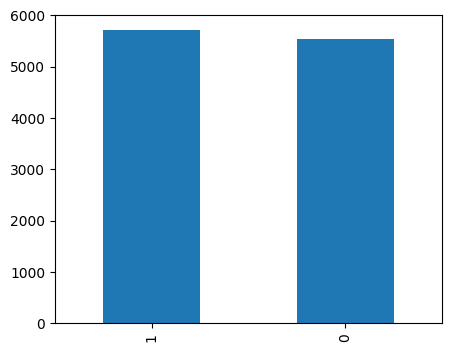

In [42]:
# 기준 모델 - 정확도 50.8%
print(df[TARGET].value_counts(normalize = True))

# 기준 모델 - 시각화 
plt.figure(figsize=(5, 4))
df[TARGET].value_counts().plot(kind = 'bar')
plt.savefig('new_data_target_barplot.png')

In [43]:
# (추가)데이터 불러오기 (데이터 표준화 과정 추가)
def new_data_load():
    """
    전역변수:
        df: 데이터 프레임
        data: 일괄 처리를 위한 넘파이 배열 데이터
        input_size: 입력 벡터 크기
        output_size: 출력 벡터 크기 
    매개변수:
        FILE_PATH: 파일 저장 위치 
    실행변수:
        features: 피쳐만 담은 컬럼명 리스트 
        df[features]: 피쳐만 담은 데이터 프레임
    """  
    # 향후 사용할 전역 변수 선언
    global df, data, input_size, output_size
    df = pd.read_csv(FILE_PATH)
    # tartget : 문자열 -> 정수형으로 변경 
    df['target'] = pd.get_dummies(df['status'])['legitimate'].astype('int')
    # 분석에 활용할 수 없는 문자형 변수 삭제 
    df = df.drop(['status', 'url'], axis = 1)
    # 중복값 제거 
    df = df.drop_duplicates(keep='first')
    # 데이터 표준화 
    features = df.drop(['target'], axis = 1).columns
    df[features] = data_standardization(df[features])

    input_size, output_size = 87, 1
    data = np.asarray(df, dtype='float32')


### 실행 결과: 새로운 데이터에 은닉층 추가 모델(최종 모델) 적용

In [49]:
# (새로운 데이터에 은닉층 추가 모델 적용) 메인 함수 선언 
# 학습률과 은닉층 노드 수 설정 
LEARNING_RATE = 0.001
set_hidden(8)

def new_data_main(epoch_count = 500, minibatch_size = 256, report = 50):
    """
    매개변수: 
        epoch_count: 에포크 수
        minibatch_size: 미니배치 크기
        report: 보고 주기 
    """
    new_data_load()
    init_model_with_hidden()
    train_and_test_with_backprop(epoch_count, minibatch_size, report)

new_data_main()

은닉층 하나를 갖는 신경망이 작동됩니다.
[Epoch 50] : Train - Loss = 0.693, Accuracy = 0.506
[Epoch 100] : Train - Loss = 0.692, Accuracy = 0.507
[Epoch 150] : Train - Loss = 0.689, Accuracy = 0.641
[Epoch 200] : Train - Loss = 0.674, Accuracy = 0.844
[Epoch 250] : Train - Loss = 0.613, Accuracy = 0.877
[Epoch 300] : Train - Loss = 0.489, Accuracy = 0.891
[Epoch 350] : Train - Loss = 0.354, Accuracy = 0.904
[Epoch 400] : Train - Loss = 0.268, Accuracy = 0.918
[Epoch 450] : Train - Loss = 0.224, Accuracy = 0.925
[Epoch 500] : Train - Loss = 0.200, Accuracy = 0.929

[참고] Result = accuracy, precision, recall, f1
Final Test: Final Result = 0.926, 0.918, 0.942, 0.930


In [50]:
# 메인 함수 선언 - 학습률 변경, 은닉층 노드 수 변경 
LEARNING_RATE = 0.005
set_hidden(32)

new_data_main()

은닉층 하나를 갖는 신경망이 작동됩니다.
[Epoch 50] : Train - Loss = 0.537, Accuracy = 0.883
[Epoch 100] : Train - Loss = 0.188, Accuracy = 0.936
[Epoch 150] : Train - Loss = 0.154, Accuracy = 0.945
[Epoch 200] : Train - Loss = 0.143, Accuracy = 0.948
[Epoch 250] : Train - Loss = 0.137, Accuracy = 0.949
[Epoch 300] : Train - Loss = 0.133, Accuracy = 0.950
[Epoch 350] : Train - Loss = 0.131, Accuracy = 0.951
[Epoch 400] : Train - Loss = 0.128, Accuracy = 0.952
[Epoch 450] : Train - Loss = 0.126, Accuracy = 0.953
[Epoch 500] : Train - Loss = 0.124, Accuracy = 0.954

[참고] Result = accuracy, precision, recall, f1
Final Test: Final Result = 0.943, 0.944, 0.941, 0.943


In [51]:
# 메인 함수 선언 - 학습률 변경, 은닉층 노드 수 변경 
LEARNING_RATE = 0.005
set_hidden([64])

new_data_main()

은닉층 1개를 갖는 다층 신경망이 작동됩니다.
[Epoch 50] : Train - Loss = 0.468, Accuracy = 0.898
[Epoch 100] : Train - Loss = 0.184, Accuracy = 0.937
[Epoch 150] : Train - Loss = 0.156, Accuracy = 0.944
[Epoch 200] : Train - Loss = 0.146, Accuracy = 0.946
[Epoch 250] : Train - Loss = 0.141, Accuracy = 0.948
[Epoch 300] : Train - Loss = 0.137, Accuracy = 0.949
[Epoch 350] : Train - Loss = 0.134, Accuracy = 0.951
[Epoch 400] : Train - Loss = 0.132, Accuracy = 0.951
[Epoch 450] : Train - Loss = 0.129, Accuracy = 0.951
[Epoch 500] : Train - Loss = 0.127, Accuracy = 0.952

[참고] Result = accuracy, precision, recall, f1
Final Test: Final Result = 0.949, 0.950, 0.950, 0.950


### 최종 모델 파이프라인: 함수 호출 관계

![Call Graph](./img/cp1.png)